In [4]:
def less_than_k(key, input_array):
    
    #                   Imports
    
    from qiskit.circuit.library import MCMT
    from qiskit import QuantumRegister, ClassicalRegister
    from qiskit import QuantumCircuit, execute
    from qiskit.circuit.library import IntegerComparator
    from qiskit import Aer
    import numpy as np
    from math import ceil, log2, pi, asin
    from qiskit.visualization import plot_histogram
    import random
    
    
    
    size_arr = len(input_array)
    qubits_needed = ceil(log2(max(input_array))) + 1 #Extra Qubit kept to have border numbers like 32, 128 etc
    
    
    
    #State preparation in uniform superposition
    #for
    #elements in the input array
    #
    #No Hardamad gates are used 
    initial_state = [(1/np.sqrt(size_arr)) if i in input_array else 0 for i in range(2**qubits_needed)]
    
    
    #Quantum Circuit Preparation
    q = QuantumRegister(2*qubits_needed,'q') #More qubits are needed to be used as ancilla in the Oracle
    c = ClassicalRegister(qubits_needed,'c')
    circuit = QuantumCircuit(q,c)
    circuit.initialize(initial_state, [q[i] for i in range(qubits_needed)]) 

    
    
    
    #Multi control z gate to be used in the diffusion matrix
    mcmt_z = MCMT('z', num_ctrl_qubits=qubits_needed-1, num_target_qubits=1)
    
    
    #Diffusion/Inversion Matrix
    def inversion(circuit, qreg):
        circuit.barrier()
        for i in range(qubits_needed):
            circuit.h(qreg[i])
            circuit.x(qreg[i])


        circuit.append(mcmt_z, range(qubits_needed))

        circuit.z(qreg[0])
        circuit.x(qreg[0])
        circuit.z(qreg[0])


        for i in range(qubits_needed-1):
            circuit.x(qreg[i+1])

        for i in range(qubits_needed):
            circuit.h(qreg[i])
            
            
    iterations = ceil(np.sqrt(size_arr)) #Can be +1 or -1 than the value.Choose while using the algo
    iterations = 2
    
    #Ancilla to |->
    circuit.x(q[qubits_needed])
    circuit.h(q[qubits_needed])
    
    
    #Main Part
    for i in range(iterations):
        #query/Oracle for comparing each entry with key and returning 1 if it is less than the key
        comparator = IntegerComparator(num_state_qubits=qubits_needed, value=key, geq=False)
        circuit = circuit.compose(comparator)
        circuit.barrier()

        #inversion
        inversion(circuit,q)
        circuit.barrier()
        
        
    #Reset Ancilla 
    circuit.h(q[qubits_needed])
    circuit.x(q[qubits_needed])
    
    
    #Measurement
    for i in range(qubits_needed):
        circuit.measure(q[i],c[i])
        
        
    job = execute(circuit,Aer.get_backend('qasm_simulator'),shots=20000)
    counts = job.result().get_counts(circuit)
    
    return (circuit.draw('mpl'))
    #return (plot_histogram(counts))
    
    

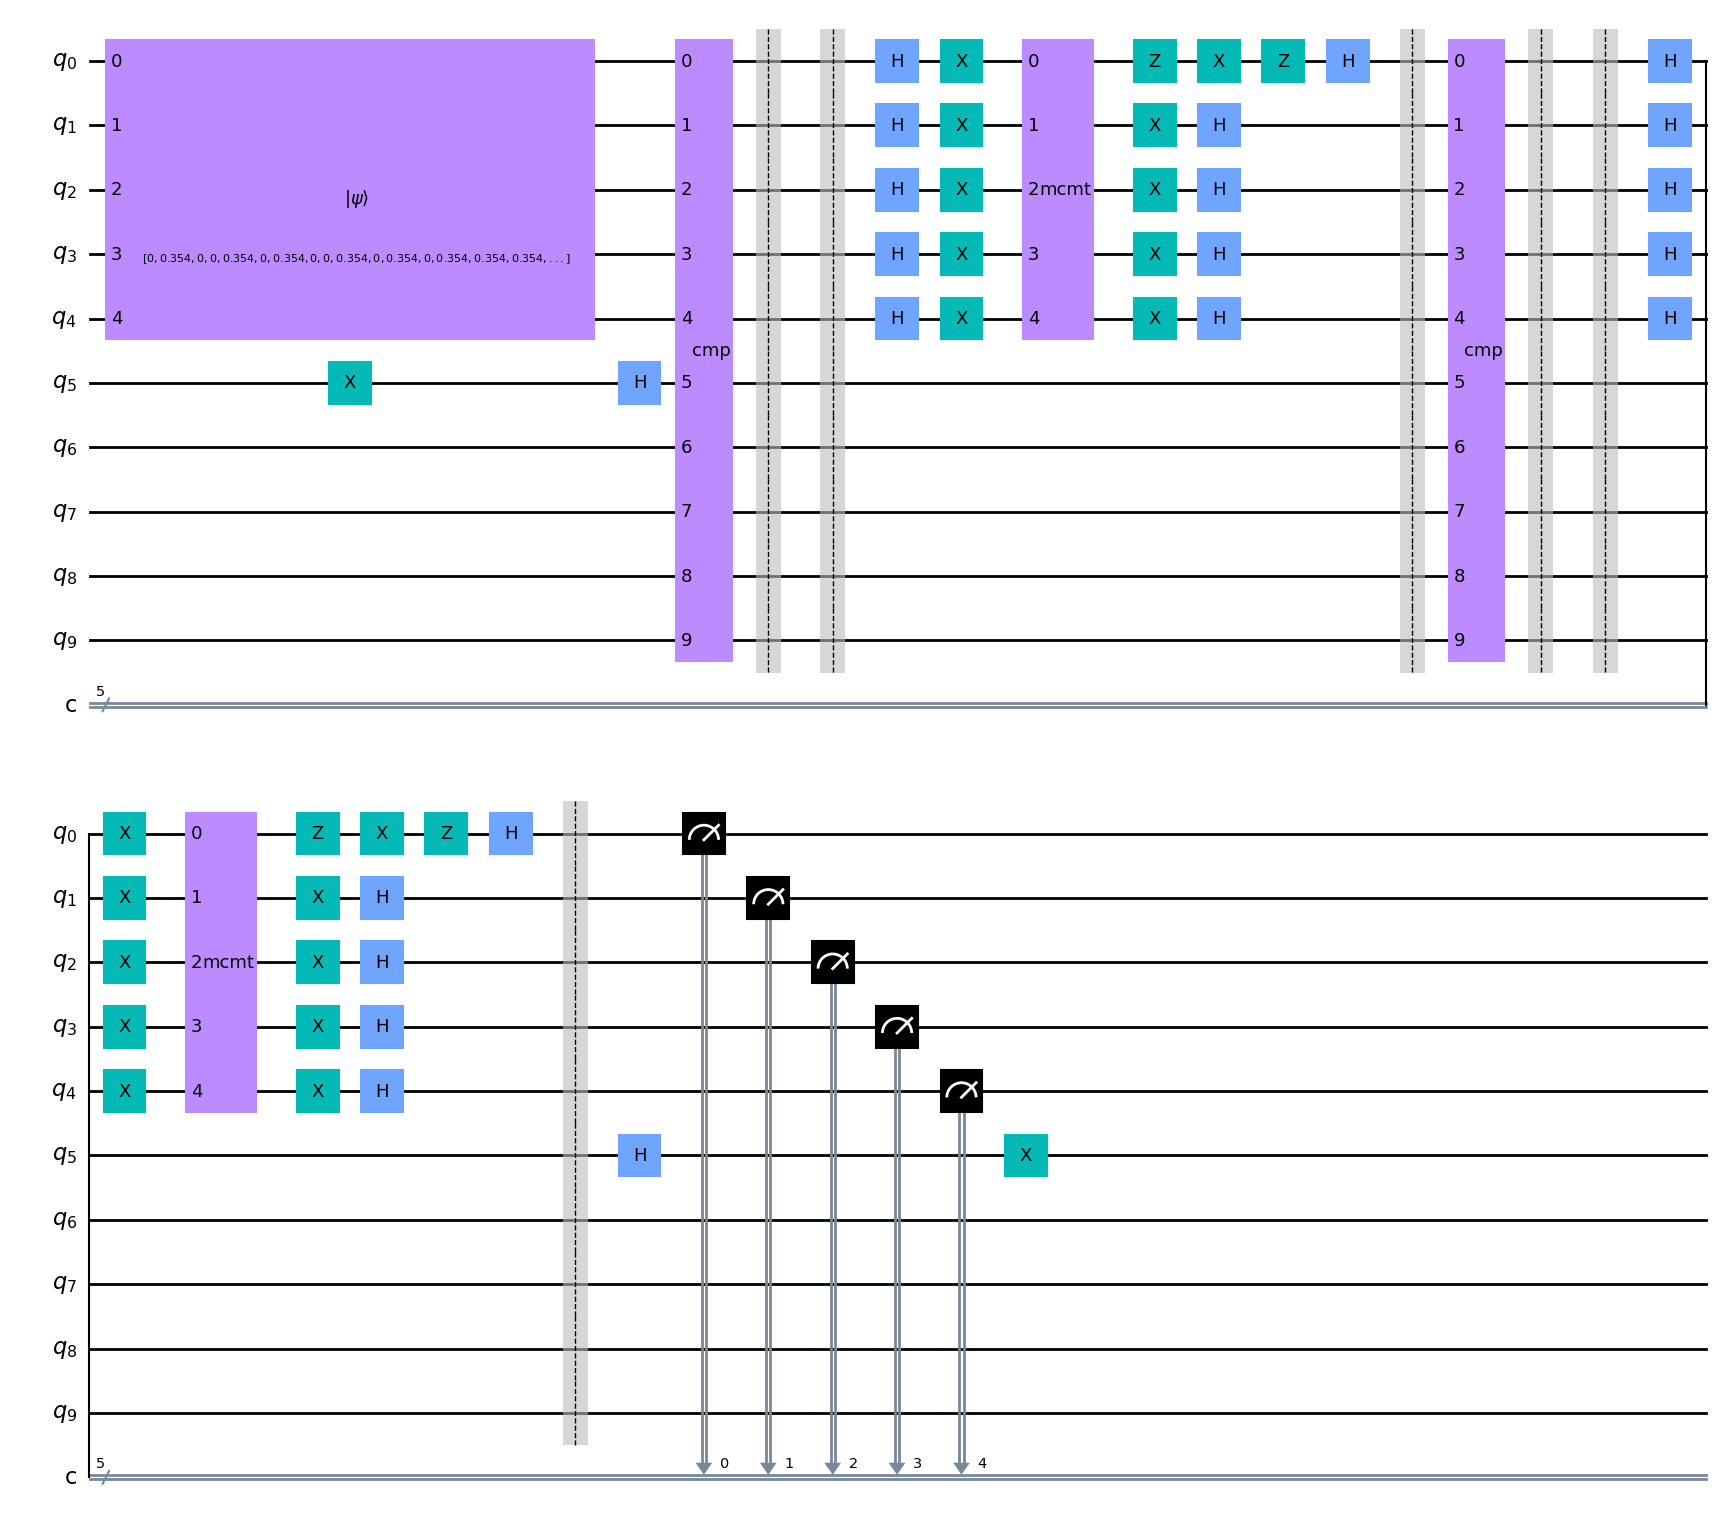

In [5]:
less_than_k(7,[4,9,11,14,1,13,6,15])